In [1]:
from scipy.special import ellipk, ellipe, ellipkm1
from numpy import pi, sqrt, linspace
from pylab import plot, xlabel, ylabel, suptitle, legend, show

import numpy as np
from matplotlib import pyplot as plt

uo = 4E-7*pi     # Permeability constant - units of H/m
Bo = lambda i, a, u=uo: i*u/2./a    # Central field = f(current, loop radius, perm. constant)
al = lambda r, a: r/a               # Alpha = f(radius of measurement point, radius of loop)
be = lambda x, a: x/a               # Beta = f(axial distance to meas. point, radius of loop)
ga = lambda x, r: x/r               # Gamma = f(axial distance, radius to meas. point)
Q = lambda r, x, a: (1 + al(r,a))**2 + be(x,a)**2   # Q = f(radius, distance to meas. point, loop radius)
k = lambda r, x, a: sqrt(4*al(r,a)/Q(r,x,a))       # k = f(radius, distance to meas. point, loop radius)
K = lambda k: ellipk(k**2.0)          # Elliptic integral, first kind, as a function of k
E = lambda k: ellipe(k**2.0)          # Elliptic integral, second kind, as a function of k

# On-Axis field = f(current and radius of loop, x of measurement point)
def Baxial(i, a, x, u=uo):
    if a == 0:
        if x == 0:
            return NaN
        else:
            return 0.0
    else:
        return (u*i*a**2)/2.0/(a**2 + x**2)**(1.5)

# Axial field component = f(current and radius of loop, r and x of meas. point)
def Bx(i, a, x, r):
    if r == 0:
        if x == 0:
            return Bo(i,a)         # central field
        else:
            return Baxial(i,a,x)   # axial field
    else:                          # axial component, any location
        return Bo(i,a)*\
            (E(k(r,x,a))*((1.0-al(r,a)**2-be(x,a)**2)/(Q(r,x,a)-4*al(r,a))) + K(k(r,x,a)))\
            /pi/sqrt(Q(r,x,a))
        
# Radial field component = f(current and radius of loop, r and x of meas. point)
def Br(i, a, x, r):
    if r == 0:
        return 0                   # no radial component on axis!
    else:                          # radial component, any location other than axis.
        return Bo(i,a)*ga(x,r)*\
            (E(k(r,x,a))*((1.0+al(r,a)**2+be(x,a)**2)/(Q(r,x,a)-4*al(r,a))) - K(k(r,x,a)))\
            /pi/sqrt(Q(r,x,a))

In [8]:
def BxCoil(i,x,r,loops, d, w, startingr):
    #i-current through loops
    #x-distance along axis
    #r-radial distance off of axis
    #loops-number of loops in spiral coil
    #d-distance between loops
    #w-width of copper trace
    #startingr-radius of first loop
    BxTotal=0
    for ii in range(1,loops+1):
        loopr = startingr+d+w/2+(ii-1)*(d+w)
        BxTotal=BxTotal+Bx(i,loopr,x,r)*10000
    return BxTotal

def BrCoil(i,x,r,loops, d, w, startingr):
    #i-current through loops
    #x-distance along axis
    #r-radial distance off of axis
    #loops-number of loops in spiral coil
    #d-distance between loops
    #w-width of copper trace
    #startingr-radius of first loop
    BrTotal=0
    for ii in range(1,loops+1):
        loopr = startingr+d+w/2+(ii-1)*(d+w)
        BrTotal=BrTotal+Br(i,loopr,x,r)*10000
    return BrTotal

def BSheet(i,x,r,w): #assumes finite width, infinite length so r is just the distance towards either edge
    #i-current
    #x-distance away from sheet
    #r-distance off axis
    #w-width of sheet
    
    return uo*i/w*1/(2*np.pi)*1/x*(np.arctan((w+r)/(x))-np.arctan((-w+r)/(x)))*10000
    

#print(BxCoil(0.9,0.002,0.00002,20,0.00012,0.001,0.002),BrCoil(0.9,0.002,0.00002,20,0.00012,0.001,0.002))
print(BSheet(0.21,0.002,0,0.03))

21.05919428226702


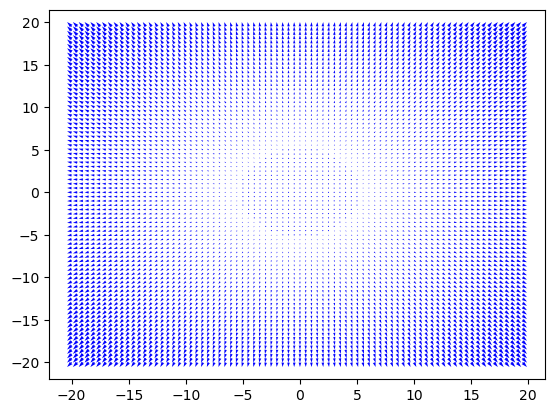

<Figure size 2560x1920 with 0 Axes>

In [25]:
X = np.arange(-20,20,0.5)
Y = np.arange(-20,20,0.5)
scale = 1000

X = X/scale
Y = Y/scale
coords = np.meshgrid(X,Y)
X = coords[0]
Y = coords[1]
r = X**2+Y**2

mag=[[BrCoil(0.9,0.002,rrr, 20, 0.00012,0.001,0.002)for rrr in rr]for rr in r]

U = mag*np.divide(X,r,out=np.zeros_like(X), where=r!=0)
V = mag*np.divide(Y,r,out=np.zeros_like(Y), where=r!=0)

fig = plt.quiver(X*scale,Y*scale,U,V,color="blue")
plt.figure(figsize=[25.6,19.2])
plt.savefig("plot.png")
plt.show()



In [44]:
axiallimit = 3 # millimeters from center
radiallimit = 0.02 # maximum radius to investigate
curveqty = 6
X = linspace(0,axiallimit)
R = linspace(0, radiallimit, curveqty)

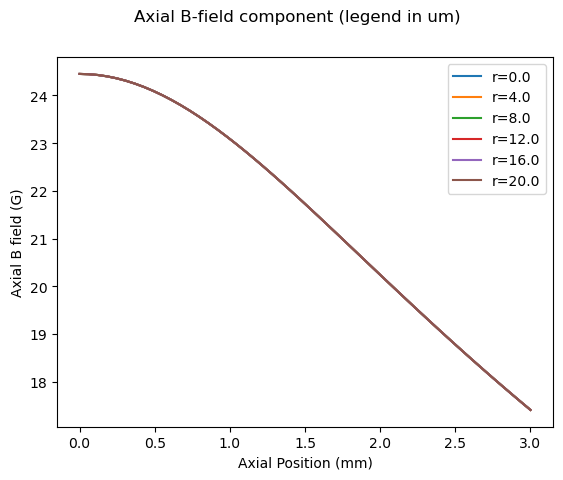

In [48]:
# [plot(X, [Bx(1.66,0.02,x,r) for x in X], label="r={0}".format(r)) for r in R]
[plot(X, [BxCoil(0.9,x/1000,r/1000,20,0.00012,0.001,0.002)+BxCoil(0.9,x/1000,r/1000,20,0.00012,0.001,0.0022) for x in X], label="r={0}".format(r*1000)) for r in R]
xlabel("Axial Position (mm)")
ylabel("Axial B field (G)")
# suptitle("Axial component of unit coil (20 mm radius, 1.66A current) B field for various measurement radii")
suptitle("Axial B-field component (legend in um)")
legend()
show()

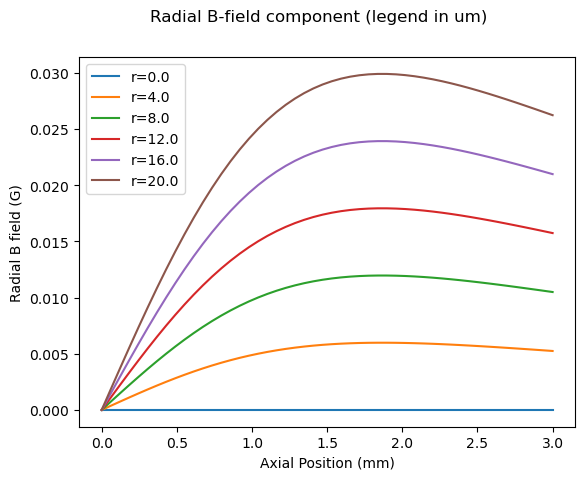

In [49]:
# [plot(X, [Br(1,1,x,r) for x in X], label="r={0}".format(r)) for r in R]
[plot(X, [BrCoil(0.9,x/1000,r/1000,20,0.00012,0.001,0.002)+BrCoil(0.9,x/1000,r/1000,20,0.00012,0.001,0.0022) for x in X], label="r={0}".format(r*1000)) for r in R]
xlabel("Axial Position (mm)")
ylabel("Radial B field (G)")
# suptitle("Radial component of unit coil (20 mm radius, 1.66 A current) B field for various measurement radii")
suptitle("Radial B-field component (legend in um)")
legend()
show()